In [9]:
from pymongo import MongoClient
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
import json
import re
from datetime import datetime

load_dotenv()
GOOGLE_API_KEY=os.environ["GOOGLE_API_KEY"]

In [22]:
mongo_url = f"mongodb://localhost:27017/"
client = MongoClient(mongo_url)
db = client.mydb
collection = db.Test_data

In [23]:
client = MongoClient('mongodb://localhost:27017/')
db = client['mydb']
collection = db['sensor']

In [24]:
type(collection)

pymongo.collection.Collection

In [25]:
# List all collections in the database
collections = db.list_collection_names()

# Check if the 'sensor' collection exists
if 'sensor' in collections:
    print("The 'polar' collection exists.")
else:
    print("The 'sensor' collection does not exist.")

The 'polar' collection exists.


In [5]:
collections

['sensor', 'Test_data']

In [44]:
llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        max_tokens=250,
        temperature=0.5)

In [8]:
try:
    client.admin.command('ismaster')
    print("MongoDB connection successful")
except Exception as e:
    print(f"MongoDB connection failed: {e}")
    exit()

MongoDB connection successful


In [27]:
prompt_template =""" You are an AI expert in providing MongoDB queries. Your task is to provide a MongoDB query to extract relevant data from the 
data collection the user possess.The user has collection of data name is sensor.
Each document in the collection represents a movie and has the following fields with their respective values,\n

   
    - '_id': Unique identifier for the document.\n
    - '_class': Class of the entity, typically representing the data structure.\n
    - 'deviceId': Identifier of the device that collected the sensor data.\n
    - 'number': Sequence number of the sensor reading.\n
    - 'code': Code representing the type of data.\n
    - 'time': Timestamp when the data was collected.\n
    - 'value': The value recorded by the sensor.\n
    - 'creationDate': Timestamp when the document was created provided in datetime format.\n
    - 'modifiedDate': Timestamp when the document was last modified provided in datetime format.\n
    - 'flag': A flag indicating the status or condition of the reading.\n
    - 'isEditedFromUser': Boolean indicating whether the document was edited by a user.\n


You will be provided with a user query where you must provide a suitable MongoDB query where the relevant data can be extracted from the collection using the MongoDB query.\n
This is important, Remember you must only provide the relevant MongoDB query only, nothing else other than the MongoDB query such as javascript should not be provided as Answers.No explanations are also needed.
"""

In [28]:
user_query = "provide me the values  for deviceId SAG_DPv3_QA3 with code B with their creation dates"

In [29]:
main_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",prompt_template,
            ),
            ("human", "user query: {user_query}"),
        ])

main_chain = main_prompt | llm 

In [30]:
ai_msg= main_chain.invoke({
        "user_query": user_query
        })
    
query_string = ai_msg.content
print(query_string)

```mongodb
db.sensor.find({ deviceId: "SAG_DPv3_QA3", code: "B" }, { _id: 0, value: 1, creationDate: 1 })
```


In [31]:
def extract_mongo_query(formatted_query_string):
    # Ensure the string is stripped of leading/trailing whitespace
    formatted_query_string = formatted_query_string.strip()
    
    # Find the index where 'db.' starts
    db_index = formatted_query_string.find("db.")
    
    # If 'db.' is found, extract the substring from that point onward
    if db_index != -1:
        formatted_query = formatted_query_string[db_index:]
    else:
        # If 'db.' is not found, return the original string (or handle as needed)
        formatted_query = formatted_query_string

    end_index = formatted_query.find("`")
    mongo_query = formatted_query[:end_index]
    
    
    # Return the clean MongoDB query string
    return mongo_query

def extract_method_collection_projection(mongo_query):
    # Remove any leading/trailing whitespace
    mongo_query = mongo_query.strip()
    
    # Find the starting point after "db."
    db_index = mongo_query.find("db.")
    
    # Extract the rest of the query starting after "db."
    query_core = mongo_query[db_index + 3:]
    
    # Find the first '.' after "db." to separate collection name and method
    method_start = query_core.find(".")
    
    # Extract collection name and method
    collection_name = query_core[:method_start]
    method_end = query_core.find("(", method_start)
    method = query_core[method_start + 1:method_end]
    
    # Extract the query inside the parentheses
    query_inside_parentheses = query_core[method_end + 1:-1]
    
    # Split the query and projection if they exist
    query_parts = query_inside_parentheses.split('}, {')
    
    # Extract query and projection
    query_part = query_parts[0] + '}'
    projection_part = '{' + query_parts[1] if len(query_parts) > 1 else None

    #Convert to JSON
    query_part = convert_to_json_dict(query_part)
    projection_part = convert_to_json_dict(projection_part)

    
    return collection_name, method, projection_part,query_part

def convert_to_json_dict(query_string):
    # Ensure the string is stripped of leading/trailing whitespace
    query_string = query_string.strip()
    
    # Replace single quotes with double quotes to make it JSON-compatible
    json_compatible_string = query_string.replace("'", '"')
    
    # Ensure keys are enclosed in double quotes
    json_compatible_string = re.sub(r'(\w+):', r'"\1":', json_compatible_string)
    
    # Convert the JSON string to a Python dictionary
    try:
        query_part = json.loads(json_compatible_string)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    
    return query_part

In [32]:
# Extract the collection name, method, and projection
mongo_query = extract_mongo_query(query_string)
print(mongo_query) 
collection_name, method, projection,query_part = extract_method_collection_projection(mongo_query)

print(f"Collection Name: {collection_name}")
print(f"Method: {method}")
print(f"Projection: {projection}")
print(f"Query Part: {query_part}")

db.sensor.find({ deviceId: "SAG_DPv3_QA3", code: "B" }, { _id: 0, value: 1, creationDate: 1 })

Collection Name: sensor
Method: find
Projection: {'_id': 0, 'value': 1, 'creationDate': 1}
Query Part: {'deviceId': 'SAG_DPv3_QA3', 'code': 'B'}


In [54]:
if method == "findOne":
    result = collection.find_one(query_part, projection)
else:
    result = list(collection.find(query_part, projection))

# Print the result
print(result)

[{'Director': 'James Cameron'}]


In [33]:
from custom_tools.mongodb_query import generate_extract_mongo_query

In [34]:
user_query = "provide me the values for deviceId SAG_DPv3_QA3 with code B with their creation dates"
results = generate_extract_mongo_query(user_query)

In [48]:
type(results)

pymongo.cursor.Cursor

In [35]:
def obtain_values(results):
    x = []  
    y = []
    for document in results:
        x.append(document['value'])
        y.append(document['creationDate'])
    return x,y

# Output the lists
print("Values:", x)
print("Creation Dates:", y)

NameError: name 'x' is not defined

In [31]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from io import BytesIO
import IPython.display as display

def plot_values(x, y):
    if not x or not y:
        print("No data to plot.")
        display_plot = False
        img_bytes = None
        return img_bytes,display_plot
    else:
    # Convert x to numeric values if they are strings
        display_plot=True
        try:
            x_numeric = [float(value) for value in x]
        except ValueError:
            print("Error converting x values to numeric.")
            return None

        # Convert datetime objects in y to matplotlib date format
        dates = [mdates.date2num(date) for date in y]

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(dates, x_numeric, marker='o', linestyle='-', color='b')

        # Format the x-axis to show dates properly
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

        #plt.xlabel('Creation Date')
        #plt.ylabel('Value')
        #plt.title('Values vs Creation Dates')
        plt.grid(True)

        # Save the plot as an image to a BytesIO object
        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close()

        #if display_plot:
        #    img_bytes.seek(0)
        #    img = display.Image(data=img_bytes.read())
        #    display.display(img)

        return img_bytes,display_plot

# Call the function to plot and get the image object
img_bytes,display_plot = plot_values(x, y)


This is a sample paragraph that introduces the plot below.


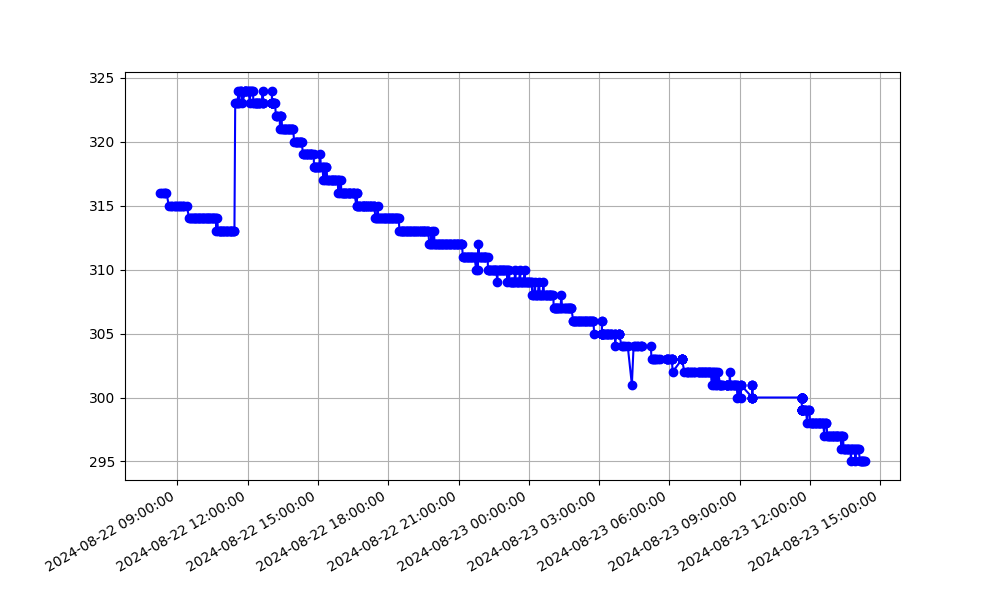

In [33]:
def print_paragraph_and_display_image(paragraph,img_bytes,display_plot):
    # Print the paragraph
    
    # Display the image if the BytesIO object is provided
    if display_plot:
        print(paragraph)
        img_bytes.seek(0)
        img = display.Image(data=img_bytes.read())
        display.display(img)
    else:
        print(paragraph)

# Example usage
paragraph = "This is a sample paragraph that introduces the plot below."
#img_bytes = plot_values(x, y, display_plot=False)  # Set display_plot=False to just get the image bytes

print_paragraph_and_display_image(paragraph, img_bytes,display_plot)

In [50]:
(img_bytes)

_io.BytesIO

In [78]:
from custom_tools.mongodb_query import generate_extract_mongo_query,access_mongodb
from custom_tools.display_tool import obtain_values,plot_values
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.tools import tool


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [46]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [47]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [48]:
llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        max_tokens=250,
        temperature=0.5)

In [79]:
@tool("get_access")
def get_access():
    '''Provides access to MongoDB and returns the collection.
    
      Args:
      None

    Returns:
      collection (pymongo.collection.collection): retrieved relevant collection from the mongodb  
    '''
    print("running get_access")
    collection = access_mongodb()

    return collection

@tool("get_mongoquery")
def get_mongoquery(user_query,collection):
    '''Provides access to MongoDB and Extracts the relevant mongo query from a mongodb provided a user query and provides the results.
    
      Args:
      user_query (str): user query which can be the question or any request related the products and services details.
      collection (pymongo.collection.collection):  relevant collection that provides access to mongodb

    Returns:
      results (pymongo.cursor.Cursor): retrieved relevant documents for the user query which is formatted into a Cursor    
    '''
    print("running get_mongoquery")
    query_part,projection = generate_extract_mongo_query(user_query)
    results = collection.find(query_part, projection)

    return results

@tool("get_values")
def get_values(results):
    '''Extracts the relevant lists from the results cursor.
    
      Args:
      results (pymongo.cursor.Cursor): retrieved relevant documents for the user query which is formatted into a Cursor  

    Returns:
      x(list),y(list): retrieved relevant lists for the results which is formatted into a Cursor    
    '''
    print("running get_values")
    x,y = obtain_values(results)

    return x,y

@tool("chart_plot")
def chart_plot(x:list,y:list):
    '''provides a plot for the provided values
    
      Args:
      x(list),y(list): relevant lists for the results which is formatted into a Cursor

    Returns:
      img_bytes(_io.BytesIO),display_plot(bool): relevant image of the chart and condition of plot present  
    '''
    print("running CHART_PLOT")
    img_bytes,display_plot = plot_values(x,y)


    return img_bytes,display_plot


In [80]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a QA AI assistant. "
            " Use the provided tools to provide answers for questions."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

In [85]:
part_1_tools = [
    get_mongoquery,
    get_values,
    chart_plot
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [86]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

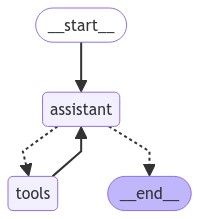

In [75]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [83]:
tutorial_questions = [
    "provide me the values for deviceId SAG_DPv3_QA3 with code B with their creation dates"]

In [87]:
import uuid

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "device_id": "SAG_DPv3_QA3",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)},config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

provide me the values for deviceId SAG_DPv3_QA3 with code B with their creation dates
================================== Ai Message ==================================
Tool Calls:
  get_mongoquery (1b7ff3f3-343e-48f9-bcac-3319cefbc8be)
 Call ID: 1b7ff3f3-343e-48f9-bcac-3319cefbc8be
  Args:
    collection: devices
    user_query: provide me the values for deviceId SAG_DPv3_QA3 with code B with their creation dates
running get_mongoquery
================================= Tool Message =================================
Name: get_mongoquery

Error: ValueError('too many values to unpack (expected 2)')
 Please fix your mistakes.
================================== Ai Message ==================================

I am sorry, I cannot fulfill your request. The tool is unable to process the query.  Please verify the information you provided.


In [2]:
user_query = "provide me the values for deviceId SAG_DPv3_QA3 with code H and its creation dates"

In [1]:
from chat_agent.mongodb_agent import db_agent

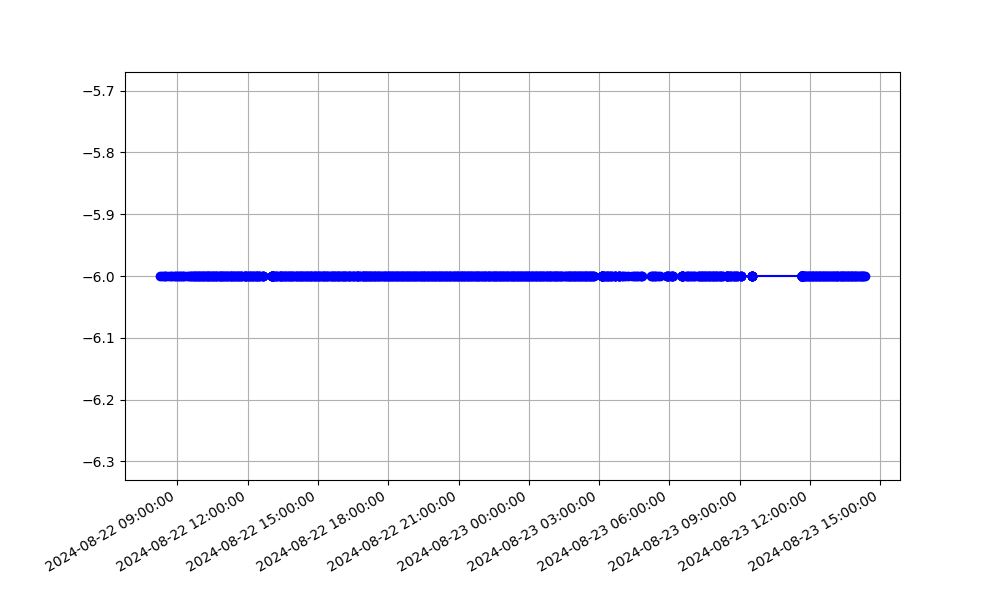

In [3]:
agent_result = db_agent(user_query)